<a href="https://colab.research.google.com/github/zoikorda/self-driving-cars/blob/main/model-based_CEMplanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install environment and visualization dependencies 
!pip install highway-env
!pip install gym pyvirtualdisplay
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg -y

# Environment
import gym
import highway_env

# Models 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
import numpy as np
from collections import namedtuple

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

# IO
from pathlib import Path

     |████████████████████████████████| 97 kB 2.2 MB/s 
     |████████████████████████████████| 11.8 MB 134 kB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [581 kB]
Hit:11 http://ppa.launchpad.

In [2]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [3]:
Tuple = namedtuple('Tuple', ['state', 'action', 'next_state'])
env = gym.make("parking-v0")

# Collect random experiences from the environment
def data_collection(env, size=1000, action_repeat=2): # size refers to the number of samples to be collected
    data, done = [], True
    for _ in trange(size, desc="Random collection of data from interaction with environment"):
        action = env.action_space.sample()
        #print(env.action_space) # the action is a one dimension matrix with to features normalised from -1 to +1 a
        #print(env.action_space.sample())
        for _ in range(action_repeat):
            previous_observation = env.reset() if done else observation
            #print(action)
            observation, reward, done, info = env.step(action)
            data.append(Tuple(torch.Tensor(previous_observation["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(observation["observation"])))
    return data

data = data_collection(env)
print("Sample transition:", data[0])

Random collection of data from interaction with environment:   0%|          | 0/1000 [00:00<?, ?it/s]

Sample transition: Tuple(state=tensor([ 0.0000,  0.0000, -0.0000,  0.0000, -0.4551,  0.8904]), action=tensor([0.6998, 0.0938]), next_state=tensor([-2.2757e-04,  4.0726e-04, -6.3786e-02,  1.2458e-01, -4.5575e-01,
         8.9011e-01]))


In [4]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size = state_size * state_size # 6*6=36
        #print(A_size)
        B_size = state_size * action_size # 6*2=12
        #print(B_size)
        self.A_enter = nn.Linear(state_size + action_size, hidden_size) # Applies a linear transformation to the incoming data: y = xA^T + b
        #print(self.A_enter)
        self.A_exit = nn.Linear(hidden_size, A_size)
        #print(self.A_exit)
        self.B_enter = nn.Linear(state_size + action_size, hidden_size)
        #print(self.B_enter)
        self.B_exit = nn.Linear(hidden_size, B_size)
        #print(self.B_exit)

    def forward(self, x, a):
        """
            Predict x_{t+1} = f(x_t, a_t)
        :param x: a batch of states
        :param a: a batch of actions
        """
        xa = torch.cat((x, a), -1) # Concatenates the given sequence of seq tensors in the given dimension.
        
        xa[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        #print(self.A_enter(xa))
        #print(F.relu(self.A_enter(xa))) # ReLu returns 0 if the input is negative otherwise return the input as it is.
        A = self.A_exit(F.relu(self.A_enter(xa)))
        #print(A.shape)
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size)) # reshape the [1,36] A matrix to [1,6,6] matrix
        #print(x.shape) # [1,6]
        #print(A.shape) # [1,6,6]
        #print(A)
        B = self.B_exit(F.relu(self.B_enter(xa)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ a.unsqueeze(-1)
        #print(self.dt) # self.dt = 0.2 
        return x + dx.squeeze()*self.dt


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])
print("Forward initial model on a sample transition:", dynamics(data[0].state.unsqueeze(0),
                                                                data[0].action.unsqueeze(0)).detach())

Forward initial model on a sample transition: tensor([[ 0.0568, -0.0162, -0.0379,  0.0112, -0.4640,  0.8601]])


Train dynamics:   0%|          | 0/1500 [00:00<?, ?it/s]

[0.02516627 0.00993389]
[0.01787989 0.00658813]
[0.01440617 0.00491602]
[0.01225723 0.00402091]
[0.01041611 0.00344317]
[0.00885714 0.00309657]
[0.00772561 0.00298194]
[0.0070234  0.00305929]
[0.0066296  0.00324525]
[0.00639746 0.00345317]
[0.00622121 0.00361332]
[0.00604511 0.00368281]
[0.00584635 0.00364401]
[0.00561726 0.00350139]
[0.00535789 0.00327638]
[0.00507948 0.00299939]
[0.0048017  0.00270445]
[0.00454622 0.00242039]
[0.0043229  0.00216591]
[0.00413216 0.00194927]
[0.00396474 0.00177015]
[0.00381063 0.00162562]
[0.0036605  0.00151186]
[0.00351084 0.00142526]
[0.00336145 0.00136264]
[0.00321458 0.00132084]
[0.00307427 0.00129463]
[0.0029431  0.00127855]
[0.00282223 0.00126682]
[0.00271095 0.00125459]
[0.00260778 0.0012376 ]
[0.00250932 0.00121358]
[0.00241195 0.00118112]
[0.00231419 0.00114077]
[0.00221571 0.00109398]
[0.00211799 0.00104376]
[0.00202314 0.00099344]
[0.00193301 0.00094583]
[0.00184867 0.00090285]
[0.00176992 0.00086501]
[0.0016964 0.0008313]
[0.00162662 0.0008

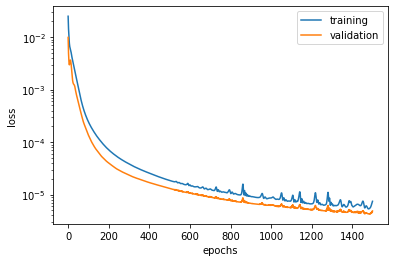

In [5]:
import torch.optim as optimizer
optimizer = optimizer.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data = data[:int(train_ratio * len(data))]
#print(train_data)
validation_data = data[int(train_ratio * len(data)):]
#print(validation_data)

def loss_function(model, data, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data
    predictions = model(states, actions)
    return loss_func(predictions, next_states)
    
def train_model(model, train_data, validation_data, epochs=1500):
    train_data_t = Tuple(*map(torch.stack, zip(*train_data)))
    #print(train_data_t) #concentrate together all states, all actions, all next_states
    validation_data_t = Tuple(*map(torch.stack, zip(*validation_data)))
    losses = np.full((epochs, 2), np.nan) # epochs=1500 , fill the matrix with nan
    for epoch in trange(epochs, desc="Train dynamics"):
        # Compute loss gradient and step optimizer
        train_loss = loss_function(model, train_data_t)
        #print(train_loss)
        validation_loss = loss_function(model, validation_data_t)
        losses[epoch] = [train_loss.detach().numpy(), validation_loss.detach().numpy()]
        print(losses[epoch])
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

train_model(dynamics, data, validation_data)

In [6]:
def predict_trajectory(current_state, actions, model, action_repeat=1):
    states_predicted = []
    for action in actions:
        for _ in range(action_repeat):
            #print(current_state)
            current_state = model(current_state, action)
            #print(current_state)
            states_predicted.append(current_state)
    return torch.stack(states_predicted, dim=0)

In [7]:
def reward_model(states, desired_state, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a desired state
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a desired state. shape: [state_size].
    :param float gamma: a discount factor
    """
    #print("states_shape", states.shape) # states is a torch.Size([1,6])
    desired_state = desired_state.expand(states.shape)
    reward_weigths = torch.Tensor([1., 0.3, 0., 0., 0.02, 0.02])
    #reward_weigths = torch.Tensor(env.unwrapped.REWARD_WEIGHTS)
    # REWARD_WEIGHTS : [1.   0.3  0.   0.   0.02 0.02]
    #print(reward_weigths) # torch.Size([6])
    rewards = -torch.pow(torch.norm((states-desired_state)*reward_weigths, p=1, dim=-1), 0.5)
    #print(rewards)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        print("TIME", time)
        rewards *= torch.pow(gamma, time)
    #print(rewards)
    return rewards

observation = env.reset()
#print(observation["observation"])
rewards = reward_model(torch.Tensor(observation["observation"]).unsqueeze(0), torch.Tensor(observation["desired_goal"]))
print("Reward of a sample transition:", rewards)


Reward of a sample transition: tensor([-0.3266])


Planned action: tensor([ 0.7557, -0.1141])
[-4.8772683 -4.8631024 -4.864107  -4.850894  -4.865884  -4.856985
 -4.8932743 -4.878279  -4.88157   -4.8935804]


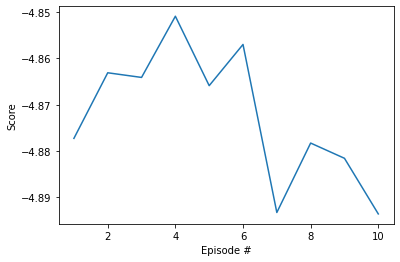

In [8]:
def cem_planner(current_state, desired_state, action_size, horizon=5, population=100, selection=10, iterations=10):
    """
      iterations (int): maximum number of training iterations
      population (int): size of population at each iteration
    """
    current_state = current_state.expand(population, -1) # Returns a new view of the :attr:`self` tensor with singleton dimensions expanded to a larger size.Passing -1 as the size for a dimension means not changing the size of that dimension.
    #print(current_state.shape) # torch.Size([100, 6])
    action_mean = torch.zeros(horizon, 1, action_size) #μ=0
    #print(action_mean) # torch.Size([5, 1, 2]) full of zeros
    action_std = torch.ones(horizon, 1, action_size) #σ=1
    #print(action_std) # torch.Size([5, 1, 2]) full of ones
    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        #print(torch.randn(horizon, population, action_size).shape) # torch.Size([5, 100, 2])
        actions = action_mean + action_std * torch.randn(horizon, population, action_size)
        #print(actions) # torch.Size([5, 100, 2])
        min=env.action_space.low.min() # min = -1
        max=env.action_space.high.max() # max = +1
        actions = torch.clamp(actions, min, max) # Clamp all elements in input into the range [ min, max ]. Let min_value and max_value be min and max, respectively
        states = predict_trajectory(current_state, actions, dynamics, action_repeat=5)
        #print(states) # torch.Size([25, 100, 6])
        # 2. Fit the distribution to the top-k performing sequences
        #print(desired_state.shape) # torch.Size([6])
        rewards = reward_model(states, desired_state).sum(dim=0) # numpy is summing across the first (0th) and only axis
        #print(rewards) # torch.Size([100]
        elite_rewards, elite_rewards_indices = rewards.topk(selection, largest=True, sorted=False) # Returns the k(10) largest elements of the given input tensor along a given dimension
        #print(elite_rewards) # torch.Size([10])
        #print(elite_rewards_indices) # torch.Size([10])
        elite_actions = actions[:, elite_rewards_indices, :] # concentrate the actions that give the maximum rewards
        #print(elite_actions) # torch.Size([5, 10, 2])
        action_mean, action_std = elite_actions.mean(dim=1, keepdim=True), elite_actions.std(dim=1, unbiased=False, keepdim=True)
        #print(action_mean) # torch.Size([5, 1, 2])
        #print(action_std) # torch.Size([5, 1, 2])
        #print(action_mean[0]) # torch.Size([1, 2])
        #print(action_mean[0].squeeze(dim=0)) # torch.Size([2])
    return action_mean[0].squeeze(dim=0), elite_rewards
 
  
# Run the planner on a sample transition
action, rewards = cem_planner(torch.Tensor(observation["observation"]),
                     torch.Tensor(observation["desired_goal"]),
                     env.action_space.shape[0])

print("Planned action:", action)
rewards = rewards.detach().numpy() # these are the elite rewards of each episode
print(rewards)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
obs = env.reset()
done =  False

# Evaluate the agent
rewards_total = []
episode_reward = 0
for _ in range(10000):
  action, rewards = cem_planner(torch.Tensor(obs["observation"]), torch.Tensor(obs["desired_goal"]), env.action_space.shape[0])
  obs, reward, done, info = env.step(action.numpy())
  episode_reward += reward
  if done or info.get('is_success', False):
    print("Reward:", episode_reward, "Success?", info.get('is_success', False))
    rewards_total.append(episode_reward)
    episode_reward = 0.0
    obs = env.reset()

Reward: -12.684292489379775 Success? True
Reward: -22.892500667687045 Success? False
Reward: -28.844239254415488 Success? False
Reward: -5.899748189380359 Success? True
Reward: -4.74766641764116 Success? True
Reward: -6.0738491245988895 Success? True
Reward: -22.85717254634085 Success? False
Reward: -25.369335033510048 Success? False
Reward: -15.873244517454065 Success? False
Reward: -17.716992801324913 Success? False
Reward: -23.89717654331791 Success? False
Reward: -18.896161959710582 Success? False
Reward: -29.01067621423249 Success? False
Reward: -3.6283308032101975 Success? True
Reward: -18.350234196038294 Success? False
Reward: -23.618759380311488 Success? False
Reward: -18.03351297140131 Success? False
Reward: -19.60103441736487 Success? False
Reward: -11.88248585001117 Success? True
Reward: -6.15354826909307 Success? True
Reward: -18.620445883094202 Success? False
Reward: -25.203031736932523 Success? False
Reward: -18.906606970393696 Success? False
Reward: -21.412262046147536 S

[-12.684292489379775, -22.892500667687045, -28.844239254415488, -5.899748189380359, -4.74766641764116, -6.0738491245988895, -22.85717254634085, -25.369335033510048, -15.873244517454065, -17.716992801324913, -23.89717654331791, -18.896161959710582, -29.01067621423249, -3.6283308032101975, -18.350234196038294, -23.618759380311488, -18.03351297140131, -19.60103441736487, -11.88248585001117, -6.15354826909307, -18.620445883094202, -25.203031736932523, -18.906606970393696, -21.412262046147536, -11.083034686556863, -10.293914244099058, -23.298120109095546, -10.123209805514541, -27.650800620951763, -22.710630585664976, -8.433343719267626, -11.238553132626818, -10.272044099549747, -9.229428872327617, -17.302509574125768, -10.792066153653774, -15.0263152232773, -8.203859196368004, -8.362936135258844, -23.08728422137535, -16.998625572044027, -10.019033140939696, -23.059922821799635, -12.43069356505842, -7.9947613475255945, -16.522409355763966, -15.541891792142827, -7.561870150164246, -26.3709273

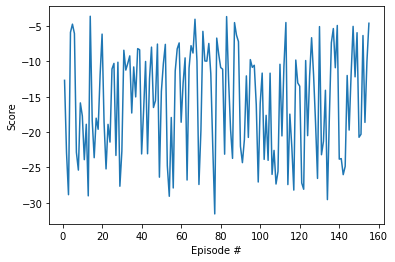

In [10]:
print(rewards_total)

import matplotlib.pyplot as plt
import numpy as np

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards_total)+1), rewards_total)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env = gym.make("parking-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
for episode in trange(5, desc="Test episodes"):
    observation, done = env.reset(), False
    while not done:
        action, rewards = cem_planner(torch.Tensor(observation["observation"]),
                             torch.Tensor(observation["desired_goal"]),
                             env.action_space.shape[0])
        observation, reward, done, info = env.step(action.numpy())
    print("REWARDS", rewards)
env.close()
show_video('./video')


Test episodes:   0%|          | 0/5 [00:00<?, ?it/s]

REWARDS tensor([-2.0098, -1.9716, -1.9997, -2.0021, -2.0394, -2.0345, -2.0376, -2.0217,
        -2.0258, -2.0488], grad_fn=<TopkBackward>)
REWARDS tensor([-1.6808, -1.5931, -1.6414, -1.6456, -1.6623, -1.6228, -1.6272, -1.6747,
        -1.7237, -1.7268], grad_fn=<TopkBackward>)
REWARDS tensor([-1.8854, -1.8155, -1.9967, -1.9631, -1.9834, -1.9964, -2.0173, -1.9975,
        -2.0166, -2.0189], grad_fn=<TopkBackward>)
REWARDS tensor([-5.1210, -5.1168, -5.1192, -5.1195, -5.1223, -5.1211, -5.1214, -5.1228,
        -5.1258, -5.1263], grad_fn=<TopkBackward>)
REWARDS tensor([-5.2072, -5.1967, -5.2030, -5.2018, -5.2055, -5.1960, -5.2171, -5.2160,
        -5.2138, -5.2172], grad_fn=<TopkBackward>)
